In [1]:
import sys
sys.path.append('..')

import copy
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from utils.data_loader import EEGDataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout_rate):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
        )
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return self.relu(out)

class ImprovedDeepMLP(nn.Module):
    def __init__(self, input_size=95, num_classes=2, dropout_rate=0.3):
        super(ImprovedDeepMLP, self).__init__()
        
        hidden_dim = 128
        
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout_rate)
        )
        
        # Residual Blockを2層
        self.res_block1 = ResidualBlock(hidden_dim, dropout_rate)
        self.res_block2 = ResidualBlock(hidden_dim, dropout_rate)
        
        self.output_layer = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.output_layer(x)
        return x

In [3]:
class EEGDataset(Dataset):
    def __init__(self, X, y, scaler=None, fit_scaler=False):
        self.labels = y
        self.features = X.values.astype(np.float32)
        
        if fit_scaler:
            self.scaler = StandardScaler()
            self.features = self.scaler.fit_transform(self.features)
        elif scaler is not None:
            self.scaler = scaler
            self.features = self.scaler.transform(self.features)
        else:
            self.scaler = None

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx], dtype=torch.long)

In [4]:
def train_one_fold(train_idx, val_idx, test_idx, X, y, groups, task_name, n_epochs=30, batch_size=64, lr=0.0001):
    # Prepare datasets
    X_train, y_train = X.iloc[train_idx], y[train_idx]
    X_val, y_val = X.iloc[val_idx], y[val_idx]
    X_test, y_test = X.iloc[test_idx], y[test_idx]
    
    train_dataset = EEGDataset(X_train, y_train, fit_scaler=True)
    val_dataset = EEGDataset(X_val, y_val, scaler=train_dataset.scaler)
    test_dataset = EEGDataset(X_test, y_test, scaler=train_dataset.scaler)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model with 3 classes
    model = ImprovedDeepMLP(input_size=95, num_classes=3).to(device)
    
    # Calculate class weights for imbalanced dataset
    count = [len(np.where(y_train == i)[0]) for i in range(3)]
    weights = [1.0 / c for c in count]
    class_weights = torch.tensor(weights, dtype=torch.float).to(device)
    
    # Loss with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Training loop with best model tracking
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Test evaluation (no threshold, use argmax)
    model.eval()
    y_pred_epochs = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Direct argmax for multi-class
            y_pred_epochs.extend(preds.cpu().numpy())
    
    # Subject-level voting
    test_groups = groups[test_idx]
    results_df = pd.DataFrame({
        'Subject_ID': test_groups,
        'True_Label': y_test,
        'Pred_Label': y_pred_epochs
    })
    
    subj_true = []
    subj_pred = []
    for subject in results_df['Subject_ID'].unique():
        subj_data = results_df[results_df['Subject_ID'] == subject]
        true_lab = subj_data['True_Label'].iloc[0]
        # Voting using predicted labels
        pred_lab = subj_data['Pred_Label'].mode()[0]
        subj_true.append(true_lab)
        subj_pred.append(pred_lab)
    
    # Calculate metrics for multi-class
    cm = confusion_matrix(subj_true, subj_pred)
    acc = accuracy_score(subj_true, subj_pred) * 100
    f1 = f1_score(subj_true, subj_pred, average='macro') * 100
    
    # Per-class sensitivity and specificity
    n_classes = 3
    sensitivities = []
    specificities = []
    
    for class_idx in range(n_classes):
        # For each class, calculate binary metrics (one-vs-rest)
        TP = cm[class_idx, class_idx]
        FN = cm[class_idx, :].sum() - TP
        FP = cm[:, class_idx].sum() - TP
        TN = cm.sum() - TP - FN - FP
        
        sens = (TP / (TP + FN) * 100) if (TP + FN) > 0 else 0
        spec = (TN / (TN + FP) * 100) if (TN + FP) > 0 else 0
        
        sensitivities.append(sens)
        specificities.append(spec)
    
    # Macro-averaged metrics
    macro_sens = np.mean(sensitivities)
    macro_spec = np.mean(specificities)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'cm': cm,
        'acc': acc,
        'sens': macro_sens,      # Macro-averaged
        'spec': macro_spec,      # Macro-averaged
        'f1': f1,                # Already macro from sklearn
        'sensitivities': sensitivities,  # Per-class [AD, FTD, CN]
        'specificities': specificities   # Per-class [AD, FTD, CN]
    }

In [5]:
# Load data
loader = EEGDataLoader(data_dir='../features')
X, y, groups = loader.get_data(task='all')

# Run 5-fold cross-validation
results = []
for fold, (train_idx, val_idx, test_idx) in enumerate(loader.get_dl_kfold_indices(X, y, groups, n_splits=5)):
    print(f"\nTraining Fold {fold+1}...")
    result = train_one_fold(train_idx, val_idx, test_idx, X, y, groups, "3-class", n_epochs=30, lr=0.0001)
    results.append(result)
    
    # Print per-fold results
    print(f"Fold {fold+1} - ACC: {result['acc']:.2f}%, SENS: {result['sens']:.2f}%, SPEC: {result['spec']:.2f}%, F1: {result['f1']:.2f}%")
    print(f"  Per-class SENS: AD={result['sensitivities'][0]:.2f}%, FTD={result['sensitivities'][1]:.2f}%, CN={result['sensitivities'][2]:.2f}%")
    print(f"  Per-class SPEC: AD={result['specificities'][0]:.2f}%, FTD={result['specificities'][1]:.2f}%, CN={result['specificities'][2]:.2f}%")

Loading data from ../features...
  AD: 14514 samples
  FTD: 8262 samples
  CN: 12012 samples

Total: 34788 samples, 95 features
Class distribution: AD=14514, FTD=8262, CN=12012
Unique subjects: 88
Data loaded successfully!


Training Fold 1...
Fold 1 - ACC: 44.44%, SENS: 44.44%, SPEC: 73.10%, F1: 41.59%
  Per-class SENS: AD=25.00%, FTD=25.00%, CN=83.33%
  Per-class SPEC: AD=80.00%, FTD=64.29%, CN=75.00%

Training Fold 2...
Fold 2 - ACC: 50.00%, SENS: 57.41%, SPEC: 76.48%, F1: 45.83%
  Per-class SENS: AD=55.56%, FTD=16.67%, CN=100.00%
  Per-class SPEC: AD=77.78%, FTD=91.67%, CN=60.00%

Training Fold 3...
Fold 3 - ACC: 52.94%, SENS: 50.00%, SPEC: 75.76%, F1: 41.27%
  Per-class SENS: AD=66.67%, FTD=0.00%, CN=83.33%
  Per-class SPEC: AD=63.64%, FTD=100.00%, CN=63.64%

Training Fold 4...
Fold 4 - ACC: 55.56%, SENS: 53.49%, SPEC: 77.87%, F1: 53.49%
  Per-class SENS: AD=57.14%, FTD=20.00%, CN=83.33%
  Per-class SPEC: AD=72.73%, FTD=69.23%, CN=91.67%

Training Fold 5...
Fold 5 - ACC: 58.82%, S

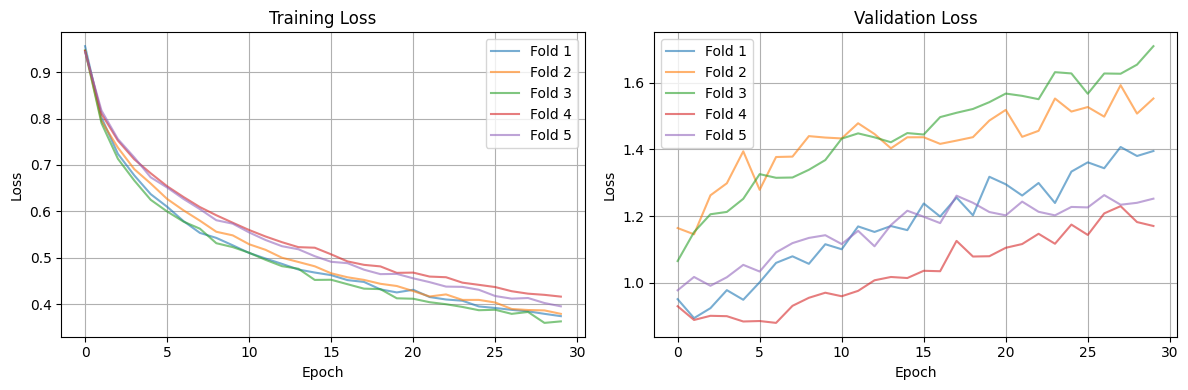

In [8]:
# Plot loss curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss curves for all folds
for i, result in enumerate(results):
    axes[0].plot(result['train_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

for i, result in enumerate(results):
    axes[1].plot(result['val_losses'], label=f'Fold {i+1}', alpha=0.6)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Cross-Validation Results (Subject-level, 3-class)
Accuracy:         52.35% ± 4.91%
Macro Sensitivity: 51.62% ± 4.30%
Macro Specificity: 76.52% ± 2.12%
Macro F1 Score:    46.98% ± 5.26%

Per-class Metrics (averaged across folds)
AD:
  Sensitivity: 50.87% ± 14.01%
  Specificity: 75.19% ± 6.53%
FTD:
  Sensitivity: 19.00% ± 11.04%
  Specificity: 80.75% ± 13.40%
CN:
  Sensitivity: 85.00% ± 8.16%
  Specificity: 73.62% ± 11.23%


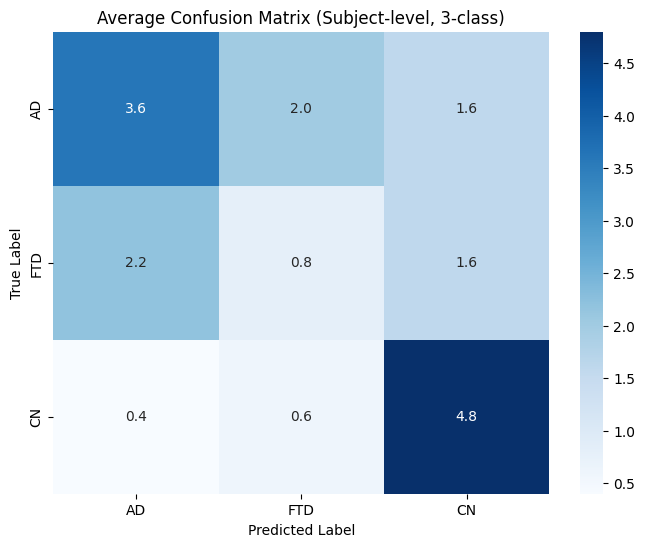

In [9]:
# Summary metrics
print("\n" + "="*50)
print("Cross-Validation Results (Subject-level, 3-class)")
print("="*50)

accs = [r['acc'] for r in results]
sens_list = [r['sens'] for r in results]
spec_list = [r['spec'] for r in results]
f1s = [r['f1'] for r in results]

print(f"Accuracy:         {np.mean(accs):.2f}% ± {np.std(accs):.2f}%")
print(f"Macro Sensitivity: {np.mean(sens_list):.2f}% ± {np.std(sens_list):.2f}%")
print(f"Macro Specificity: {np.mean(spec_list):.2f}% ± {np.std(spec_list):.2f}%")
print(f"Macro F1 Score:    {np.mean(f1s):.2f}% ± {np.std(f1s):.2f}%")

# Per-class metrics
print("\n" + "="*50)
print("Per-class Metrics (averaged across folds)")
print("="*50)

class_names = ['AD', 'FTD', 'CN']
for class_idx, class_name in enumerate(class_names):
    sens_per_class = [r['sensitivities'][class_idx] for r in results]
    spec_per_class = [r['specificities'][class_idx] for r in results]
    
    print(f"{class_name}:")
    print(f"  Sensitivity: {np.mean(sens_per_class):.2f}% ± {np.std(sens_per_class):.2f}%")
    print(f"  Specificity: {np.mean(spec_per_class):.2f}% ± {np.std(spec_per_class):.2f}%")

# Average confusion matrix (3x3)
avg_cm = np.mean([r['cm'] for r in results], axis=0)
plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['AD', 'FTD', 'CN'],
            yticklabels=['AD', 'FTD', 'CN'])
plt.title('Average Confusion Matrix (Subject-level, 3-class)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()